# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in Turi Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!

## Fire up Turi Create

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

In [30]:
loans = pd.read_csv('lending-club-data.csv', low_memory = False)
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           122607 non-null  int64  
 1   member_id                    122607 non-null  int64  
 2   loan_amnt                    122607 non-null  int64  
 3   funded_amnt                  122607 non-null  int64  
 4   funded_amnt_inv              122607 non-null  int64  
 5   term                         122607 non-null  object 
 6   int_rate                     122607 non-null  float64
 7   installment                  122607 non-null  float64
 8   grade                        122607 non-null  object 
 9   sub_grade                    122607 non-null  object 
 10  emp_title                    115767 non-null  object 
 11  emp_length                   118516 non-null  object 
 12  home_ownership               122607 non-null  object 
 13 

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. We have done this in previous assignments, so we won't belabor this here.

In [31]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [32]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis = 1)

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [33]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [34]:
loans_data = loans[[target] + features]

In [35]:
loans_data.isnull().sum()

safe_loans                0
grade                     0
sub_grade_num             0
short_emp                 0
emp_length_num            0
home_ownership            0
dti                       0
purpose                   0
payment_inc_ratio         4
delinq_2yrs              29
delinq_2yrs_zero         29
inq_last_6mths           29
last_delinq_none          0
last_major_derog_none     0
open_acc                 29
pub_rec                  29
pub_rec_zero             29
revol_util                0
total_rec_late_fee        0
int_rate                  0
total_rec_int             0
annual_inc                4
funded_amnt               0
funded_amnt_inv           0
installment               0
dtype: int64

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [36]:
loans_data = loans_data.dropna()

# Count the number of rows after remove missing values
num_rows = len(loans_data)
print('keeping %s ' % num_rows)

keeping 122578 


In [37]:
cat_cols = [col for col in loans_data.columns if loans_data[col].dtype == 'object']
onehot = pd.get_dummies(loans_data[cat_cols], prefix = cat_cols)
loans_data.drop(cat_cols, axis = 1, inplace = True)
laons_data = pd.concat([loans_data, onehot], axis = 1)

In [42]:
import json
train_idx, valid_idx = [], [] 
with open ('module-8-assignment-1-train-idx.json', 'r') as js:
    js_reader = json.load(js)
    for idx in js_reader:
        train_idx.append(idx)
with open ('module-8-assignment-1-validation-idx.json', 'r') as js:
    js_reader = json.load(js)
    for idx in js_reader:
        valid_idx.append(idx)
train_data = loans_data.iloc[train_idx]
validation_data = loans_data.iloc[valid_idx]

In [39]:
len(train_data), len(validation_data)

(37219, 9284)

Fortunately, there are not too many missing values. We are retaining most of the data.

## Make sure the classes are balanced

We saw in an earlier assignment that this dataset is also imbalanced. We will undersample the larger class (safe loans) in order to balance out our dataset. We used `seed=1` to make sure everyone gets the same results.

In [26]:
safe_loans_raw = loans_cols[loans_cols[target] == 1]
risky_loans_raw = loans_cols[loans_cols[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac = percentage, random_state = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46294


In [28]:
cat_cols = [col for col in loans_data.columns if loans_data[col].dtype == 'object']
onehot = pd.get_dummies(loans_data[cat_cols], prefix = cat_cols)
loans_data.drop(cat_cols, axis = 1, inplace = True)
laons_data = pd.concat([loans_data, onehot], axis = 1)

In [29]:
loans_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0.0,1.0,9.4,0.0,15.27,435.17,30000.0,2500,2500,59.83
6,-1,0.4,0,5,5.55,4.57170,0.0,1.0,2.0,1,...,0.0,1.0,32.6,0.0,21.28,294.94,40000.0,5600,5600,152.39
7,-1,1.0,1,1,18.08,9.71600,0.0,1.0,0.0,1,...,0.0,1.0,36.5,0.0,12.69,533.42,15000.0,5375,5350,121.45
10,-1,0.2,1,1,10.08,12.21520,0.0,1.0,1.0,1,...,0.0,1.0,91.7,0.0,13.49,570.26,30000.0,9000,9000,305.38
12,-1,0.4,0,4,7.06,3.90888,0.0,1.0,2.0,1,...,0.0,1.0,55.5,0.0,10.65,1393.42,100000.0,10000,10000,325.74


**Checkpoint:** You should now see that the dataset is balanced (approximately 50-50 safe vs risky loans).

**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Split data into training and validation sets

We split the data into training data and validation data. We used `seed=1` to make sure everyone gets the same results. We will use the validation data to help us select model parameters.

In [16]:
train_data, valid_data = train_test_split(loans_data,
                                          test_size = 0.2,
                                          random_state = 1)

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [Turi Create user guide](https://apple.github.io/turicreate/docs/api/generated/turicreate.boosted_trees_classifier.BoostedTreesClassifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees. To cap the ensemble classifier at 5 trees, we call the function with **max_iterations=5** (recall that each iterations corresponds to adding a tree). We set `validation_set=None` to make sure everyone gets the same results.

In [44]:
model_5 = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 5)
X_train = train_data.drop(target, axis = 1)
y_train = train_data[target]
model_5.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=5)

# Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [45]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0.0,1.0,93.9,0.0,9.91,823.48,92000.0,15000,15000,483.38
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0.0,1.0,59.1,0.0,11.71,1622.21,25000.0,8500,8500,281.15
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0.0,1.0,59.5,0.0,16.77,719.11,50004.0,5000,5000,123.65
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,0.0,1.0,62.1,0.0,8.90,696.99,100000.0,5000,5000,158.77


### Predicting on sample validation data

For each row in the **sample_validation_data**, write code to make **model_5** predict whether or not the loan is classified as a **safe loan**.

**Hint:** Use the `predict` method in `model_5` for this.

In [46]:
X_valid_sample, y_valid_sample = sample_validation_data.drop(target, axis = 1), sample_validation_data[target]
y_hat_sample = model_5.predict(X_valid_sample)

In [48]:
y_hat_sample

array([ 1,  1, -1,  1], dtype=int64)

**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `model_5` get correct?

### Prediction probabilities

For each row in the **sample_validation_data**, what is the probability (according **model_5**) of a loan being classified as **safe**? 

**Hint:** Set `output_type='probability'` to make **probability** predictions using `model_5` on `sample_validation_data`:

In [49]:
model_5.predict_proba(X_valid_sample)

array([[0.42774309, 0.57225691],
       [0.46590848, 0.53409152],
       [0.53807833, 0.46192167],
       [0.40038826, 0.59961174]])

**Quiz Question:** According to **model_5**, which loan is the least likely to be a safe loan?

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**: Use the `.evaluate()` method in the model.

In [50]:
X_valid = validation_data.drop(target, axis = 1)
y_valid = validation_data[target]
y_hat_valid = model_5.predict(X_valid)

In [51]:
model_5.score(X_valid, y_valid)

0.6610297285652736

Calculate the number of **false positives** made by the model.

<AxesSubplot:>

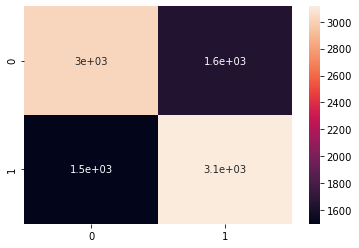

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_valid, y_hat_valid), annot = True)

In [55]:
confusion_matrix(y_valid, y_hat_valid)

array([[3023, 1649],
       [1498, 3114]], dtype=int64)

**Quiz Question**: What is the number of **false positives** on the **validation_data**?

Calculate the number of **false negatives** made by the model.

In [ ]:
#### 1498

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

**Quiz Question**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

In [57]:
cost_of_mistakes = (1498 * 10000) + (1649 * 20000)
print(cost_of_mistakes)

47960000


**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra 3% improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [58]:
y_hat_prob_valid = model_5.predict_proba(X_valid)

In [67]:
validation_data['prediction'] = y_hat_prob_valid[:, 1]

<ipython-input-67-1aaa6a6a876d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['prediction'] = y_hat_prob_valid[:, 1]


**Checkpoint:** For each row, the probabilities should be a number in the range **[0, 1]**. We have provided a simple check here to make sure your answers are correct.

In [70]:
print("Your loans      : %s\n" % validation_data['prediction'].head(4))
print("Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325])

Your loans      : 24    0.461922
41    0.599612
60    0.479872
93    0.406859
Name: prediction, dtype: float64

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [71]:
top_5 = validation_data.sort_values(by = 'prediction', ascending = False)

In [79]:
top_5_index = top_5.iloc[:5, :].index
loans.loc[top_5_index, 'grade']

12768    A
92079    A
34615    A
67183    A
2902     A
Name: grade, dtype: object

**Quiz Question**: What grades are the top 5 loans?

Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [80]:
down_5 = validation_data.sort_values(by = 'prediction', ascending = True)
down_5_index = down_5.iloc[:5, :].index
loans.loc[down_5_index, 'grade']

84508     C
58794     C
27502     C
101746    D
114781    D
Name: grade, dtype: object

**Checkpoint:** You should expect to see 5 loans with the grade ['**D**', '**C**', '**C**', '**C**', '**B**'] or with ['**D**', '**C**', '**B**', '**C**', '**C**'].

## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 

Let's get sarted with a model with **max_iterations = 10**:

In [83]:
model_10 = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 10)
model_10.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=10)

Now, train 4 models with **max_iterations** to be:
* `max_iterations = 50`, 
* `max_iterations = 100`
* `max_iterations = 200`
* `max_iterations = 500`. 

Let us call these models **model_50**, **model_100**, **model_200**, and **model_500**. You can pass in `verbose=False` in order to suppress the printed output.

**Warning:** This could take a couple of minutes to run.

In [86]:
model_50 = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 50)
model_50.fit(X_train, y_train)
model_100 = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 100)
model_100.fit(X_train, y_train)
model_200 = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 200)
model_200.fit(X_train, y_train)
model_500 = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 500)
model_500.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=500)

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `.evaluate` method.

In [87]:
print(model_10.score(X_valid, y_valid))
print(model_50.score(X_valid, y_valid))
print(model_100.score(X_valid, y_valid))
print(model_200.score(X_valid, y_valid))
print(model_500.score(X_valid, y_valid))

0.6639379577768203
0.6789099526066351
0.684080137871607
0.6827875915553641
0.6799870745368376


**Quiz Question:** Which model has the **best** accuracy on the **validation_data**?

**Quiz Question:** Is it always true that the model with the most trees will perform best on test data?

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 

First, make sure this block of code runs on your computer.

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [94]:
training_errors, validation_errors = [], []
training_errors.append(1 - model_10.score(X_train, y_train))
training_errors.append(1 - model_50.score(X_train, y_train))
training_errors.append(1 - model_100.score(X_train, y_train))
training_errors.append(1 - model_200.score(X_train, y_train))
training_errors.append(1 - model_500.score(X_train, y_train))
# validation
validation_errors.append(1 - model_10.score(X_valid, y_valid))
validation_errors.append(1 - model_50.score(X_valid, y_valid))
validation_errors.append(1 - model_100.score(X_valid, y_valid))
validation_errors.append(1 - model_200.score(X_valid, y_valid))
validation_errors.append(1 - model_500.score(X_valid, y_valid))

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

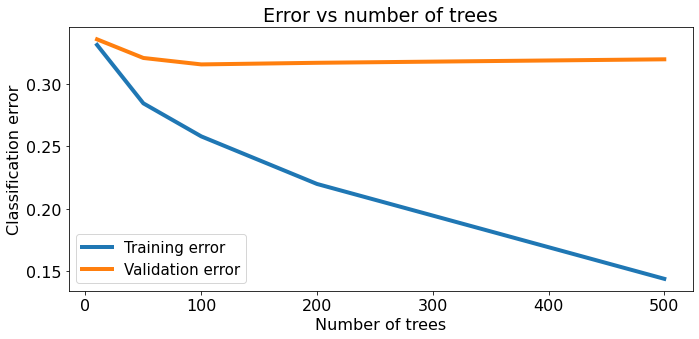

In [95]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Quiz Question**: Does the training error reduce as the number of trees increases?

**Quiz Question**: Is it always true that the validation error will reduce as the number of trees increases?